In [10]:
!apt-get update -y


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [11]:
!apt-get install -y openjdk-11-jdk-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.29+7-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.


# Apache Spark with Hadoop downloading

In [12]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2025-11-28 06:59:28--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz.2’

spark-3.2.1-bin-had 100%[===================>] 260.01M  1.48MB/s    in 3m 33s  

2025-11-28 07:03:02 (1.22 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz.2’ saved [272637746/272637746]



In [13]:
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

# Installing findspark helper

In [14]:
!pip install -q findspark pyspark==3.2.1

In [15]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [17]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

# CREATING SPARK SESSION

In [19]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Diabetes Classification") \
    .master("local[*]") \
    .getOrCreate()

spark


# Loading and showing the data

In [20]:
df = spark.read.csv("/content/diabetes_prediction_dataset.csv", header=True, inferSchema=True)
df.show(5)

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
only showing top 5 rows



## Basic Info

In [21]:
print("Total Rows:", df.count())


Total Rows: 100000


In [22]:
print("Columns:", df.columns)
df.printSchema()

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



## Missing Values Count

In [23]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|gender|age|hypertension|heart_disease|smoking_history|bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|     0|  0|           0|            0|              0|  0|          0|                  0|       0|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+



# Summary Statistics

In [24]:
df.describe().show()


+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|summary|gender|              age|      hypertension|     heart_disease|smoking_history|              bmi|       HbA1c_level|blood_glucose_level|           diabetes|
+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|  count|100000|           100000|            100000|            100000|         100000|           100000|            100000|             100000|             100000|
|   mean|  null|41.88585600000013|           0.07485|           0.03942|           null|27.32076709999422|5.5275069999983275|          138.05806|              0.085|
| stddev|  null|22.51683987161704|0.2631504702289171|0.1945930169980986|           null|6.636783416648357|1.0706720918835468|  40.70813604870383|0.27888308976661896|
|   

# Data visualisation

In [47]:
pdf = df.toPandas()
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(style="whitegrid")
import pandas as pd


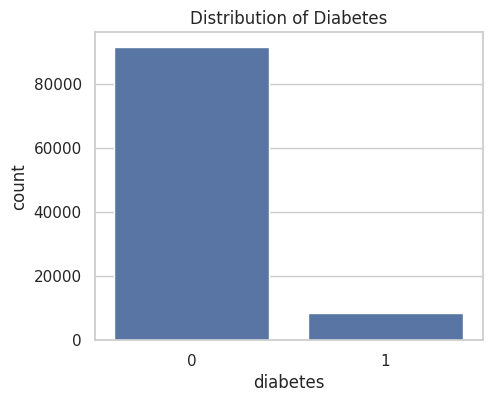

In [29]:
plt.figure(figsize=(5,4))
sns.countplot(data=pdf, x="diabetes")
plt.title("Distribution of Diabetes")
plt.show()


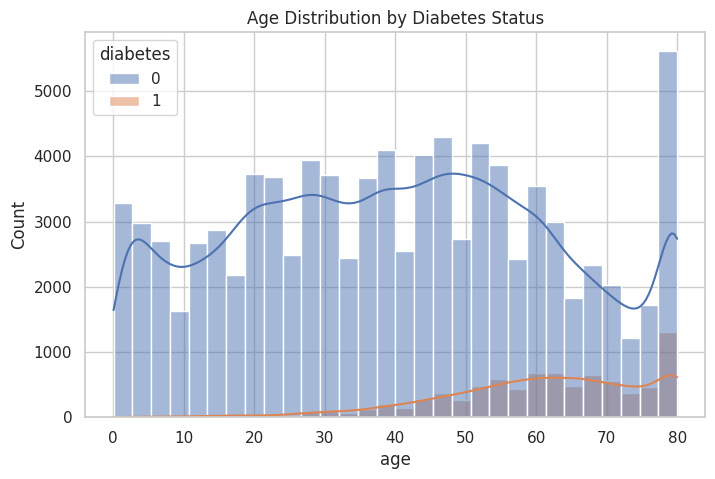

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(data=pdf, x="age", hue="diabetes", bins=30, kde=True)
plt.title("Age Distribution by Diabetes Status")
plt.show()


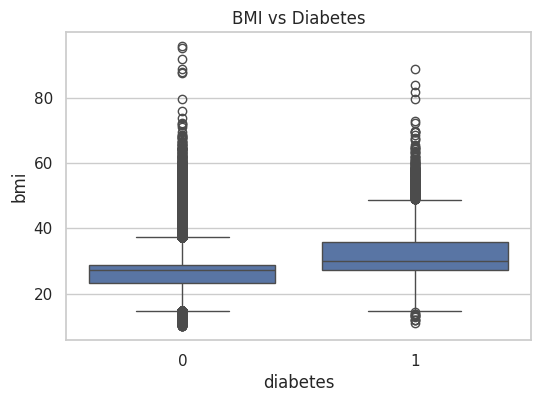

In [31]:
plt.figure(figsize=(6,4))
sns.boxplot(data=pdf, x="diabetes", y="bmi")
plt.title("BMI vs Diabetes")
plt.show()


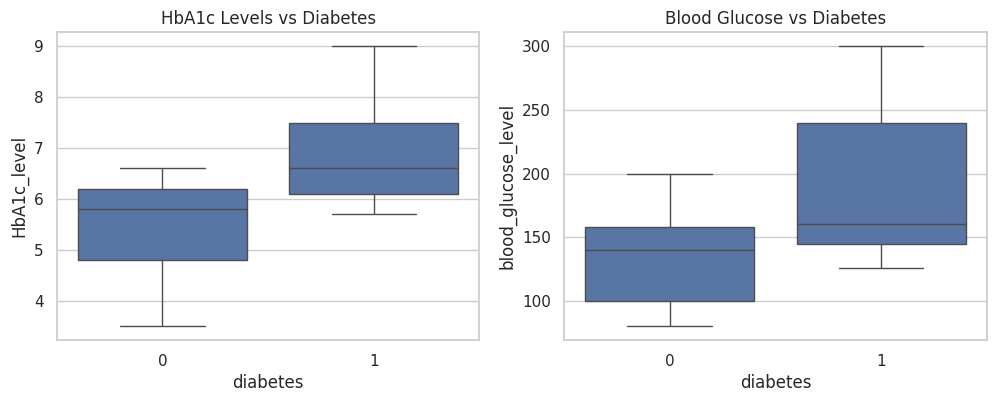

In [32]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

sns.boxplot(data=pdf, x="diabetes", y="HbA1c_level", ax=axes[0])
sns.boxplot(data=pdf, x="diabetes", y="blood_glucose_level", ax=axes[1])

axes[0].set_title("HbA1c Levels vs Diabetes")
axes[1].set_title("Blood Glucose vs Diabetes")
plt.show()


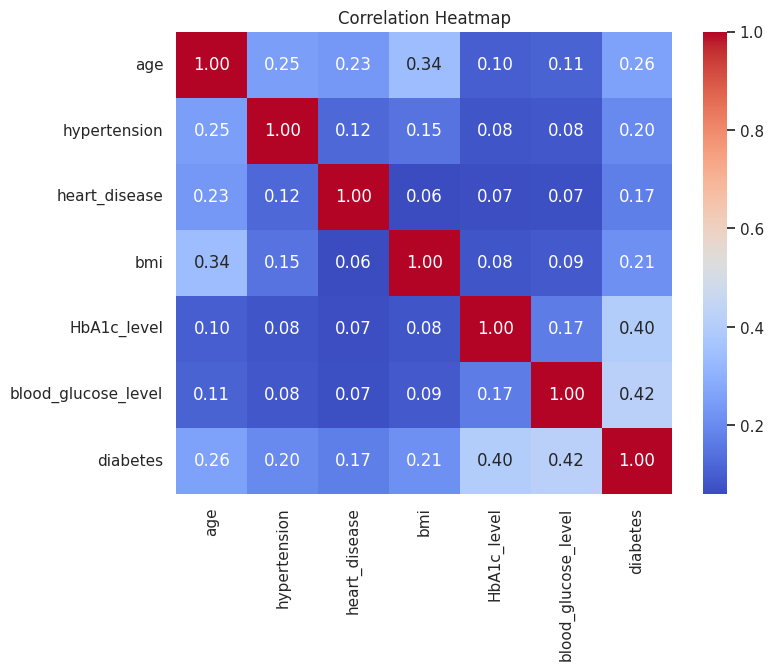

In [33]:
plt.figure(figsize=(8,6))
corr = pdf.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


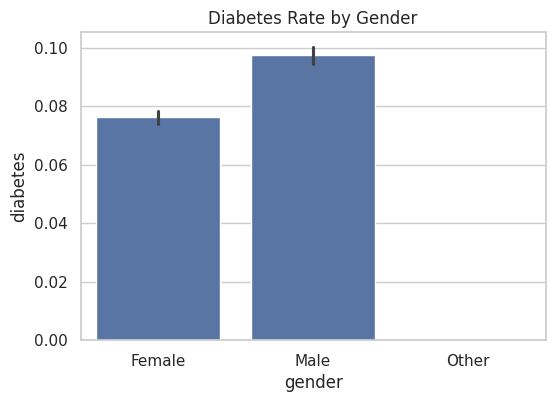

In [34]:
plt.figure(figsize=(6,4))
sns.barplot(x="gender", y="diabetes", data=pdf)
plt.title("Diabetes Rate by Gender")
plt.show()


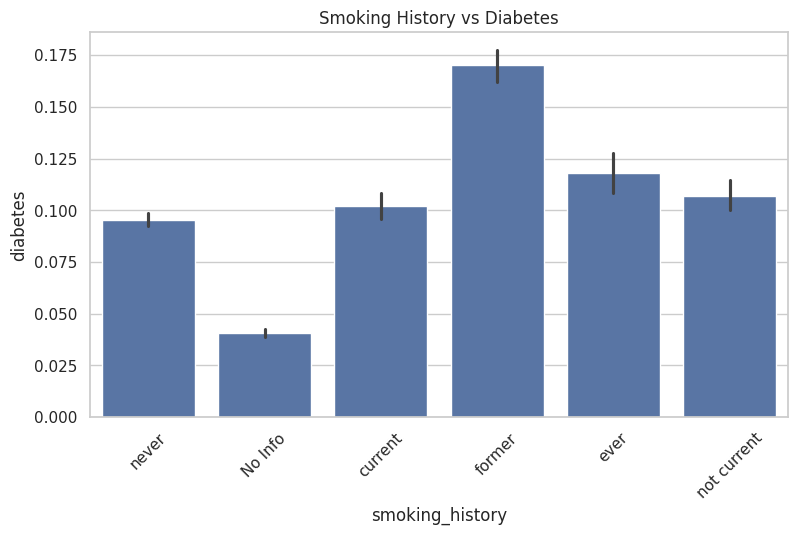

In [35]:
plt.figure(figsize=(9,5))
sns.barplot(x="smoking_history", y="diabetes", data=pdf)
plt.xticks(rotation=45)
plt.title("Smoking History vs Diabetes")
plt.show()


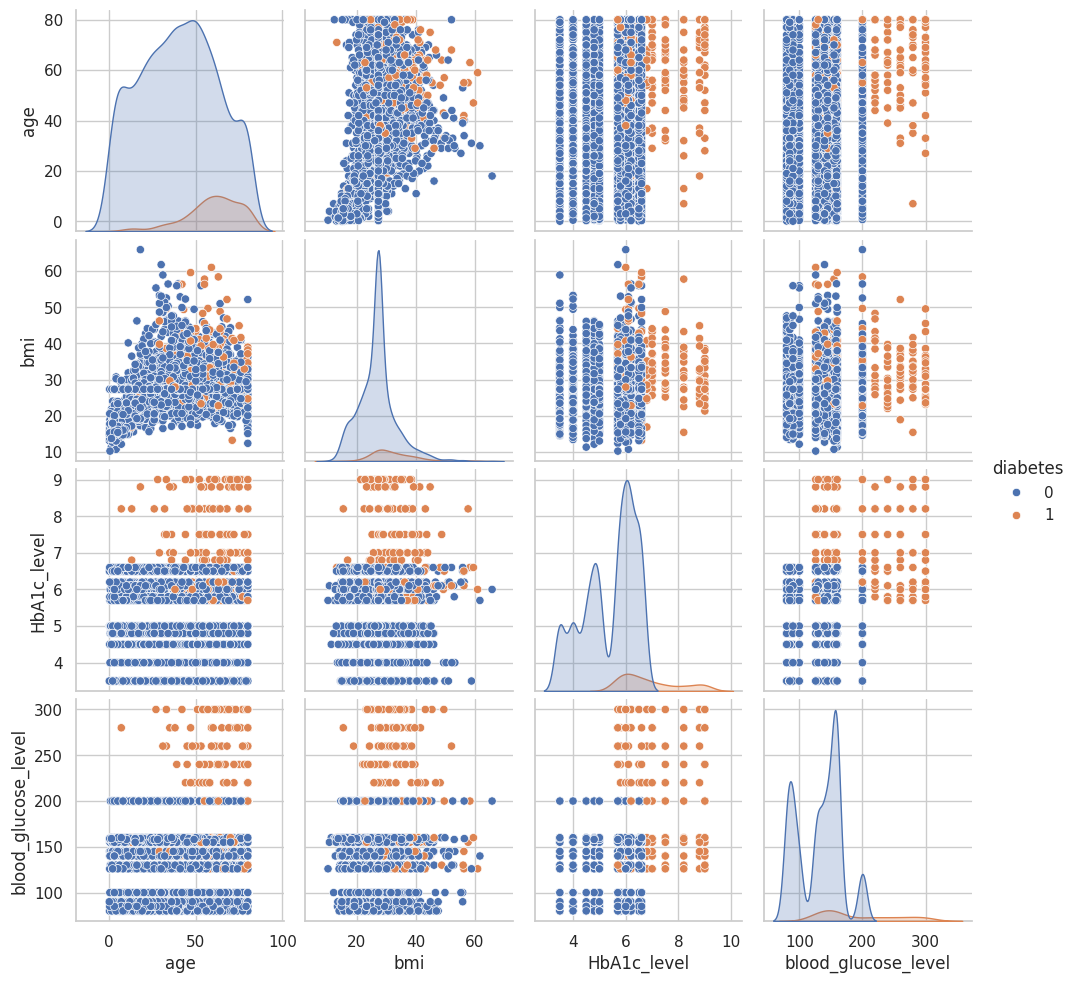

In [36]:
sns.pairplot(pdf[["age","bmi","HbA1c_level","blood_glucose_level","diabetes"]].sample(3000), hue="diabetes")
plt.show()


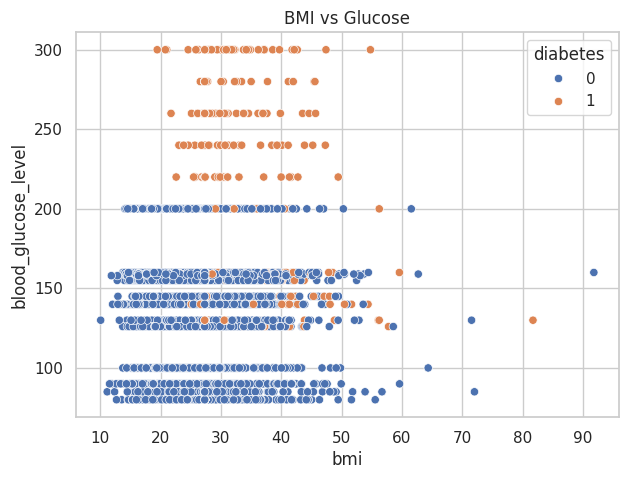

In [37]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=pdf.sample(5000), x="bmi", y="blood_glucose_level", hue="diabetes")
plt.title("BMI vs Glucose")
plt.show()


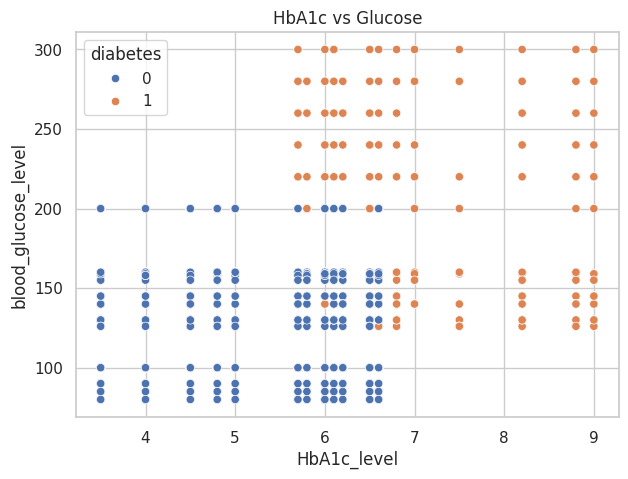

In [38]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=pdf.sample(5000), x="HbA1c_level", y="blood_glucose_level", hue="diabetes")
plt.title("HbA1c vs Glucose")
plt.show()


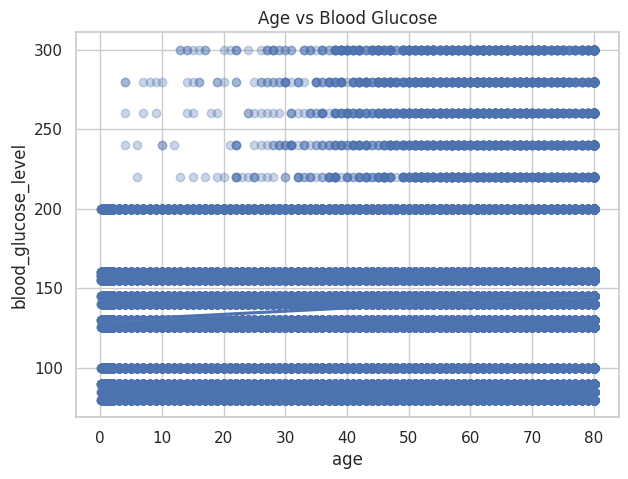

In [39]:
plt.figure(figsize=(7,5))
sns.regplot(data=pdf, x="age", y="blood_glucose_level", scatter_kws={'alpha':0.3})
plt.title("Age vs Blood Glucose")
plt.show()


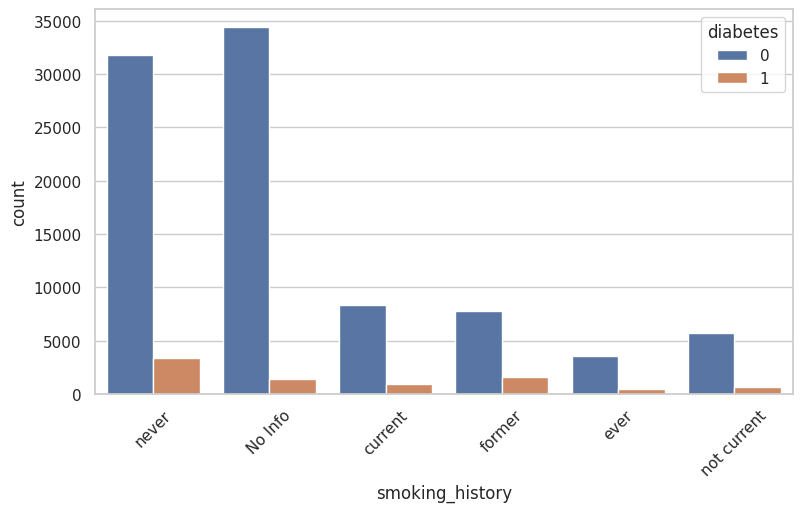

In [40]:
plt.figure(figsize=(9,5))
sns.countplot(data=pdf, x="smoking_history", hue="diabetes")
plt.xticks(rotation=45)
plt.show()


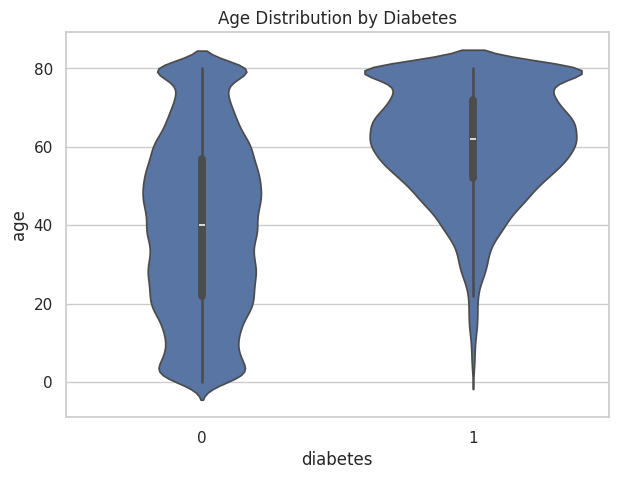

In [41]:
plt.figure(figsize=(7,5))
sns.violinplot(data=pdf, x="diabetes", y="age")
plt.title("Age Distribution by Diabetes")
plt.show()


# Preparing Data & Features

In [48]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Categorical Columns
categorical_cols = ["gender", "smoking_history"]

# Indexers
indexers = [StringIndexer(inputCol=c, outputCol=c+"_index") for c in categorical_cols]

# One-Hot Encoding
encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_ohe") for c in categorical_cols]

# Numerical Columns
numeric_cols = ['age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level']

# Feature Vector
assembler = VectorAssembler(
    inputCols=[c+"_ohe" for c in categorical_cols] + numeric_cols,
    outputCol="features"
)

## Data selection and train test spliting


In [49]:
# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
model_pipeline = pipeline.fit(df)
processed_df = model_pipeline.transform(df)

# Select final columns
final_df = processed_df.select("features", col("diabetes").cast("int").alias("label"))

# Train-Test Split
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)


# Helper function for model evaluation

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Function to generate Classification Report
def classification_report_model(pred_df, model_name):
    pdf = pred_df.select("label", "prediction").toPandas()
    print(f"\n===== {model_name} Classification Report =====")
    print(classification_report(pdf['label'], pdf['prediction']))
    return pdf

# Function to plot Confusion Matrix
def plot_confusion_matrix(pdf, model_name):
    cm = confusion_matrix(pdf['label'], pdf['prediction'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes','Diabetes'],
                yticklabels=['No Diabetes','Diabetes'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Function to plot ROC-AUC Curve
def plot_roc_curve(pred_df, model_name):
    pdf = pred_df.select("probability", "label").toPandas()
    pdf['prob'] = pdf['probability'].apply(lambda x: float(x[1]))
    fpr, tpr, _ = roc_curve(pdf['label'], pdf['prob'])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")


# Machine learning model


# Training Logistic regression

In [51]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_df)
lr_pred = lr_model.transform(test_df)


## Classification Report for Logistic regression

In [52]:
lr_pdf = classification_report_model(lr_pred, "Logistic Regression")


===== Logistic Regression Classification Report =====
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18442
           1       0.87      0.63      0.73      1657

    accuracy                           0.96     20099
   macro avg       0.92      0.81      0.85     20099
weighted avg       0.96      0.96      0.96     20099



## Confusion Matrix for Logistic regression

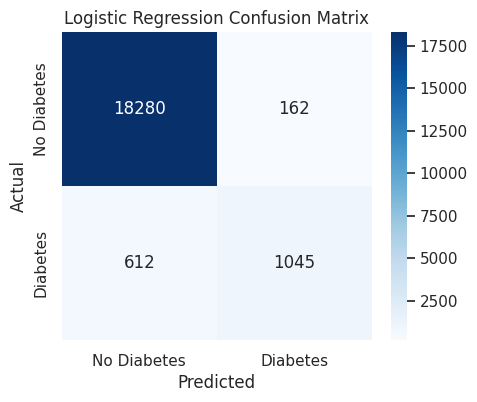

In [53]:
plot_confusion_matrix(lr_pdf, "Logistic Regression")

## ROC Curve for Logistic regression

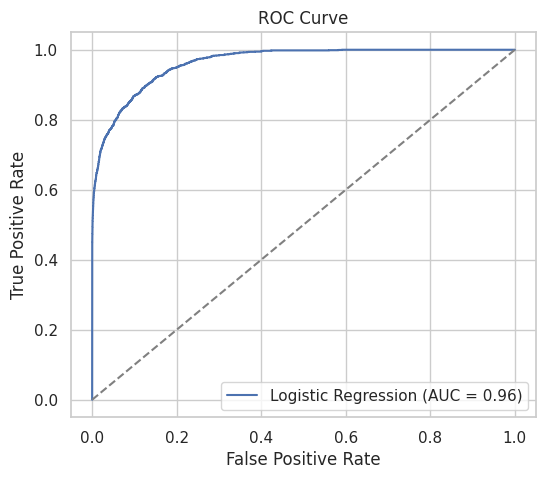

In [54]:
plt.figure(figsize=(6,5))
plot_roc_curve(lr_pred, "Logistic Regression")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# **Training Random Forest**

In [55]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=50)
rf_model = rf.fit(train_df)
rf_pred = rf_model.transform(test_df)

## Classification Report for Random forest

In [56]:
rf_pdf = classification_report_model(rf_pred, "Random Forest")


===== Random Forest Classification Report =====
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18442
           1       1.00      0.67      0.80      1657

    accuracy                           0.97     20099
   macro avg       0.99      0.83      0.89     20099
weighted avg       0.97      0.97      0.97     20099



## Confusion Matrix for Random forest

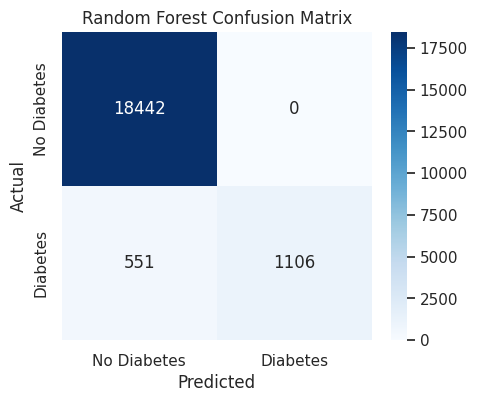

In [57]:
plot_confusion_matrix(rf_pdf, "Random Forest")

## ROC Curve for Random forest

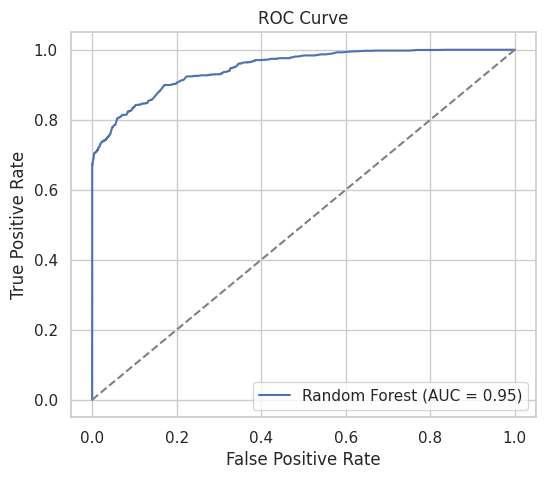

In [58]:
plt.figure(figsize=(6,5))
plot_roc_curve(rf_pred, "Random Forest")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Training GBT model

In [68]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='label', maxIter=50)
gbt_model = gbt.fit(train_df)
gbt_pred = gbt_model.transform(test_df)


## Classification Report for gradient boosting

In [69]:
gbt_pdf = classification_report_model(gbt_pred, "Gradient Boosted Trees")


===== Gradient Boosted Trees Classification Report =====
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18442
           1       1.00      0.67      0.80      1657

    accuracy                           0.97     20099
   macro avg       0.99      0.83      0.89     20099
weighted avg       0.97      0.97      0.97     20099



## Confusion matrix for Gradient boosting

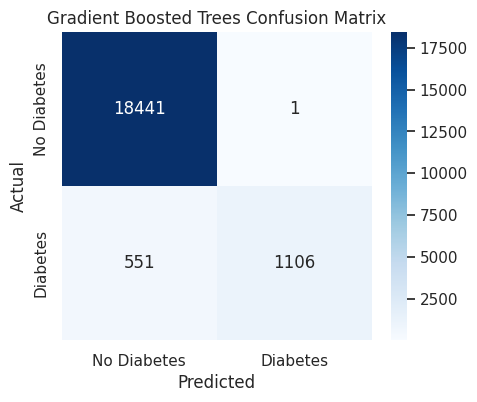

In [66]:
plot_confusion_matrix(gbt_pdf, "Gradient Boosted Trees")


## ROC-AUC for gradient boosting

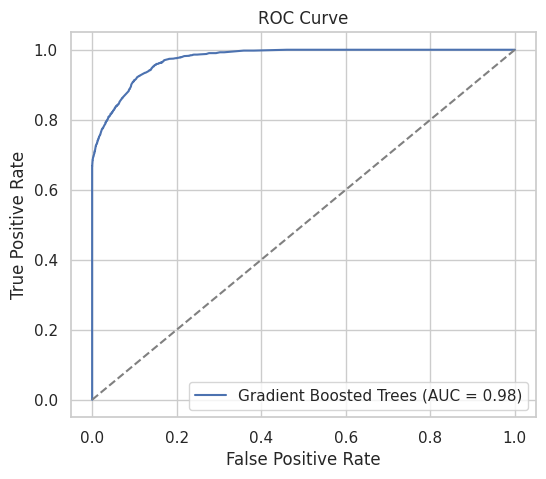

In [67]:
plt.figure(figsize=(6,5))
plot_roc_curve(gbt_pred, "Gradient Boosted Trees")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# ROC-Comparison

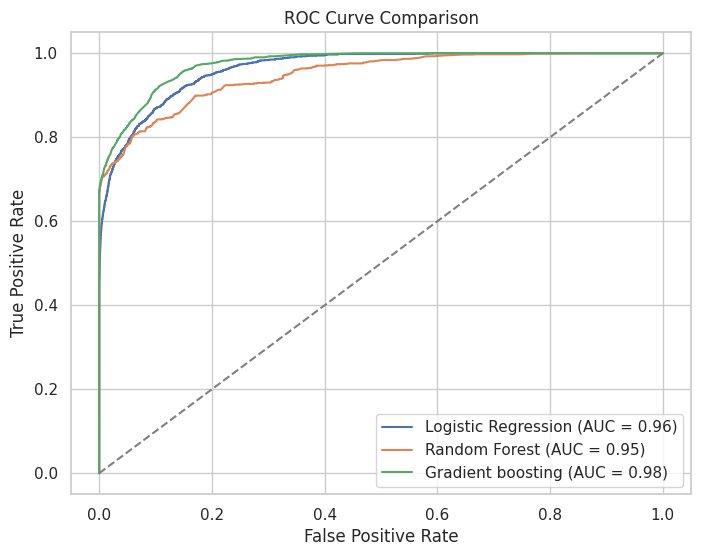

In [70]:
plt.figure(figsize=(8,6))
plot_roc_curve(lr_pred, "Logistic Regression")
plot_roc_curve(rf_pred, "Random Forest")
plot_roc_curve(gbt_pred, "Gradient boosting")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# Accuracy comparison

In [71]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

accuracy_dict = {
    "Logistic Regression": evaluator.evaluate(lr_pred),
    "Random Forest": evaluator.evaluate(rf_pred),
    "Gradient Boosted Trees": evaluator.evaluate(gbt_pred)
}

accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=["Model", "Accuracy"])
print(accuracy_df)

                    Model  Accuracy
0     Logistic Regression  0.961491
1           Random Forest  0.972586
2  Gradient Boosted Trees  0.972536


/tmp/ipython-input-4263309558.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x="Model", y="Accuracy", data=accuracy_df, palette="viridis")


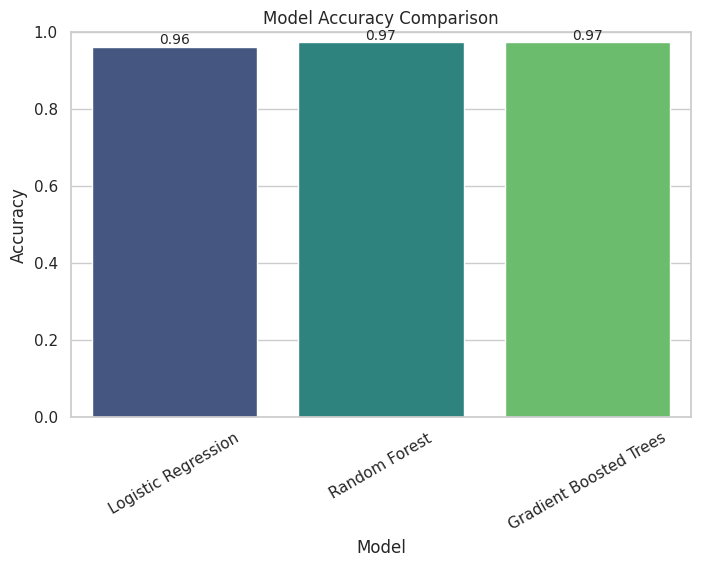

In [75]:
plt.figure(figsize=(8,5))
bar_plot = sns.barplot(x="Model", y="Accuracy", data=accuracy_df, palette="viridis")

plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=30)

for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(f'{height:.2f}',
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom', fontsize=10)

plt.show()
